# INT303 CW1: Web Scraping & Data Analysis

Zichen Qiu 2252705

# Task 1: Web Scraping 

### Data Fields Collected
- **Title** - TV show name
- **First air date** - Extracted from the earliest episode in the episodes list
- **End date** - Extracted from the most recent episode in the episodes list  
- **Rating** - User rating score from the show's information panel
- **Genres** - Show categories extracted from the genres section
- **Status** - Current status (Running/Ended) from the status field
- **Network or Channel** - Broadcasting platform (TV network or streaming service)
- **Summary** - Plot description from meta tags
- **Tvmaze Link** - Direct link to the show on TV Maze

### Air Date Extraction Process

The first air date and end date are extracted from the episode list page (`/shows/{id}/episodes`) rather than the main show page. This ensures accurate dating based on actual episode broadcasts. Example for The Witcher:
- **First air date**: `2019-12-20` (Season 1, Episode 1: "The End's Beginning")
- **End date**: `2025-10-30` (Season 4, Episode 8: "Baptisme of Fire")

### Attention

Data is collected by **randomly** selecting a page from the specified number of pages (excluding pages that have already been crawled) and then crawling all TV shows on that page until the ***target_count*** TV shows are reached. 

Therefore, the TV shows in this .csv file can be considered a **random sample**, and data duplication caused by crawling all TV shows from the first page to the target number of TV shows is avoided.


In [30]:
import requests
import re
import csv
import time
import random
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime

class TVMazeScraper:
    """A scraper class for retrieving TV show data from TVMaze."""
    def __init__(self):
        self.base_url = "https://www.tvmaze.com"
        # Use a session for persistent parameters and connection pooling
        self.session = requests.Session()
        # Set common request headers to mimic a browser
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
        })

    def get_shows_list(self, page=1):
        """Fetches the TV show list page content for a given page number."""
        url = f"{self.base_url}/shows"
        params = {'page': page}

        try:
            # Send GET request with page parameter and a timeout
            response = self.session.get(url, params=params, timeout=10)
            response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
            print(f"Successfully retrieved page {page}, status code: {response.status_code}")
            return response.text
        except requests.exceptions.RequestException as e:
            print(f"Error getting page {page} data: {e}")
            return None

    def extract_show_links(self, html_content):
        """Extracts individual TV show detail page links using BeautifulSoup and regex."""
        soup = BeautifulSoup(html_content, 'html.parser')
        show_links = []

        print("Analyzing page structure...")

        all_links = soup.find_all('a', href=True)
        for link in all_links:
            href = link['href']
            # Regex to match show detail pages, e.g., /shows/1/under-the-dome
            if re.match(r'/shows/\d+/[^/]+', href):
                full_url = urljoin(self.base_url, href)
                if full_url not in show_links:
                    show_links.append(full_url)

        print(f"Found {len(show_links)} TV show links")
        return show_links

    def get_show_details(self, show_url):
        """Fetches the HTML content for a single TV show's detail page."""
        try:
            print(f"Accessing: {show_url}")
            response = self.session.get(show_url, timeout=10)
            response.raise_for_status()
            return response.text
        except requests.exceptions.RequestException as e:
            print(f"Error getting TV show details {show_url}: {e}")
            return None

    def get_episodes_dates(self, show_url):
        """Extracts the first and last episode air dates from the show's episodes list page."""
        try:
            episodes_url = f"{show_url}/episodes"
            
            print(f"Getting episodes list: {episodes_url}")
            response = self.session.get(episodes_url, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            episodes_data = []
            
            # Find all episode rows
            episode_articles = soup.find_all('article', class_='episode-row')
            
            if not episode_articles:
                # Debugging hook: save page if no episodes are found
                with open('debug_episodes_page.html', 'w', encoding='utf-8') as f:
                    f.write(response.text)
            
            for i, article in enumerate(episode_articles):
                try:
                    cells = article.find_all('div', class_='cell')
                    
                    if len(cells) > 1:
                        date_cell = cells[1]
                        date_text = date_cell.get_text().strip()
                        
                        # Regex match expected date format (e.g., Dec 01, 2024)
                        if re.match(r'\w{3} \d{1,2}, \d{4}', date_text):
                            try:
                                # Parse the date string into a datetime object
                                parsed_date = datetime.strptime(date_text, '%b %d, %Y')
                                
                                episode_info = ""
                                if len(cells) > 2:
                                    episode_info = cells[2].get_text().strip()
                                
                                episodes_data.append({
                                    'date': parsed_date,
                                    'date_str': parsed_date.strftime('%Y-%m-%d'),
                                    'raw_text': date_text,
                                    'episode_info': episode_info
                                })
                                
                            except Exception as e:
                                print(f"  Failed to parse date: {date_text}, error: {e}")
                                continue
                        else:
                            # Debugging info (optional: print date format mismatch)
                            pass
                    else:
                        print(f"  Episode {i+1}: insufficient cells: {len(cells)}")
                
                except Exception as e:
                    print(f"  Error processing episode {i+1}: {e}")
                    continue
            
            if episodes_data:
                # Sort episodes by date to find first and last
                episodes_data.sort(key=lambda x: x['date'])
                first_episode = episodes_data[0]
                last_episode = episodes_data[-1]
                
                return first_episode['date_str'], last_episode['date_str']
            else:
                print("No episode dates found")
                return None, None
                
        except Exception as e:
            print(f"Error getting episode dates: {e}")
            return None, None
        
    def parse_show_details(self, html_content, show_url):
        """Parses the TV show detail page to extract specific data fields."""
        soup = BeautifulSoup(html_content, 'html.parser')

        show_data = {
            'Title': '',
            'First air date': '',
            'End date': '',
            'Rating': '',
            'Genres': '',
            'Status': '',
            'Network or Channel': '',
            'Summary': '',
            'Tvmaze Link': ''
        }

        try:
            # Extract Title from H1 or Title tag
            title_elem = soup.find('h1') or soup.find('title')
            if title_elem:
                title_text = title_elem.get_text().strip()
                show_data['Title'] = title_text.replace(' - TV Maze', '').replace(' | TVmaze', '').strip()

            # Extract Summary from Open Graph meta tag
            summary_meta = soup.find('meta', property='og:description')
            if summary_meta and summary_meta.get('content'):
                show_data['Summary'] = summary_meta['content'].strip()

            # Locate the general info panel
            info_panel = soup.find('section', id='general-info-panel')
            if not info_panel:
                info_panel = soup.find('section', class_='callout')

            if info_panel:
                # Extract Genres
                genres_elem = info_panel.find('strong', string=re.compile(r'Genres', re.IGNORECASE))
                if genres_elem:
                    genres_parent = genres_elem.parent
                    if genres_parent:
                        genre_spans = genres_parent.find_all('span')
                        
                        # Use a set for unique, non-composite genre names
                        valid_genres = set() 
                        
                        # Collect all potential genre texts first
                        all_potential_texts = [
                            span.get_text().strip() 
                            for span in genre_spans 
                            if span.get_text().strip() not in ['', 'Genres:']
                        ]

                        # Sort by length (shortest first) to easily identify simple genres before composite ones
                        all_potential_texts.sort(key=len)

                        for genre_text in all_potential_texts:
                            # 1. Standard filter (non-empty and max length check, kept at 16 for safety)
                            if not genre_text or len(genre_text) >= 16:
                                continue

                            # 2. Key Check: If this text contains any other valid genre we've already found, 
                            #    it's likely the longer, incorrect concatenated string (e.g., 'AdventureFantasy' contains 'Adventure').
                            is_composite_bug = False
                            for valid in valid_genres:
                                # Replace spaces for robust checking, and ensure they are not identical strings
                                if valid != genre_text and valid.replace(' ', '') in genre_text.replace(' ', ''):
                                    is_composite_bug = True
                                    break
                            
                            if not is_composite_bug:
                                valid_genres.add(genre_text)
                                
                        if valid_genres:
                            # Join the unique, correctly separated genres (sorted for consistency)
                            show_data['Genres'] = ', '.join(sorted(list(valid_genres)))
                
                show_data['Tvmaze Link'] = show_url

                # Extract Network/Channel, checking for 'Web channel' first
                web_channel_elem = info_panel.find('strong', string=re.compile(r'Web channel', re.IGNORECASE))
                if web_channel_elem:
                    network_elem = web_channel_elem.find_next('a')
                    if network_elem:
                        show_data['Network or Channel'] = network_elem.get_text().strip()
                
                # Fallback to general 'Network' if no 'Web channel' found
                if not show_data['Network or Channel']:
                    network_elem = info_panel.find('strong', string=re.compile(r'Network', re.IGNORECASE))
                    if network_elem:
                        network_link = network_elem.find_next('a')
                        if network_link:
                            show_data['Network or Channel'] = network_link.get_text().strip()

                # Extract Status
                status_elem = info_panel.find('strong', string=re.compile(r'Status', re.IGNORECASE))
                if status_elem:
                    status_text = status_elem.parent.get_text().replace('Status:', '').strip()
                    # Clean up the status text
                    status_text = re.split(r'[;,]', status_text)[0].strip()
                    
                    if 'running' in status_text.lower():
                        show_data['Status'] = 'Running'
                    elif 'ended' in status_text.lower():
                        show_data['Status'] = 'Ended'
                    else:
                        show_data['Status'] = status_text

                # Extract Rating
                rating_span = info_panel.find('span', itemprop='ratingValue')
                if rating_span:
                    show_data['Rating'] = rating_span.get_text().strip()
                else:
                    rating_elem = info_panel.find('b', itemprop='ratingValue')
                    if rating_elem:
                        show_data['Rating'] = rating_elem.get_text().strip()

                # Get Air Dates by calling a dedicated function
                print("Getting episode air dates...")
                first_air_date, end_date = self.get_episodes_dates(show_url)
                
                if first_air_date:
                    show_data['First air date'] = first_air_date
                    print(f"✓ Set first air date: {first_air_date}")
                else:
                    print("✗ Failed to get first air date")
                    
                if end_date:
                    show_data['End date'] = end_date
                    print(f"✓ Set end date: {end_date}")
                else:
                    print("✗ Failed to get end date")

                # Handle running shows without a clear end date
                if not show_data['End date'] and show_data['Status'] == 'Running':
                    show_data['End date'] = 'Still Present'
                    print("ℹ Set end date to: Still Present")

                print(f"Final dates - First: {show_data['First air date']}, End: {show_data['End date']}")

        except Exception as e:
            print(f"Error parsing page: {e}")
            import traceback
            traceback.print_exc()

        return show_data

    def scrape_tv_shows(self, target_count=200, MAX_PAGES = 64):
        """
        Main scraping function. It selects pages randomly (1 to MAX_PAGES)
        until the target count is reached.
        """
        shows_data = []
        processed_urls = set()
        processed_pages = set() # Track pages already attempted to ensure random selection of unvisited pages
        MAX_PAGES = MAX_PAGES # Total page limit for TV show list as specified by user
        
        print("Starting TV Maze data scraping with random page selection...")

        while len(shows_data) < target_count and len(processed_pages) < MAX_PAGES:
            # 1. Randomly select an unvisited page number
            available_pages = [p for p in range(1, MAX_PAGES + 1) if p not in processed_pages]
            if not available_pages:
                print("All available pages have been processed.")
                break
                
            page = random.choice(available_pages)
            processed_pages.add(page) # Mark the page as processed
            
            print(f"\n=== Processing Random Page {page} (Progress: {len(shows_data)}/{target_count}) ===")

            html_content = self.get_shows_list(page)
            if not html_content:
                print(f"Unable to get page content for page {page}")
                # Short delay after a failed page fetch
                time.sleep(random.uniform(2, 3)) 
                continue

            show_links = self.extract_show_links(html_content)
            if not show_links:
                print(f"No TV show links found on page {page}")
                time.sleep(random.uniform(2, 3))
                continue

            successful_count = 0
            for show_url in show_links:
                if len(shows_data) >= target_count:
                    break

                if show_url in processed_urls:
                    continue

                processed_urls.add(show_url)

                detail_html = self.get_show_details(show_url)
                if not detail_html:
                    time.sleep(random.uniform(2, 3)) # Delay after failed detail fetch
                    continue

                show_data = self.parse_show_details(detail_html, show_url)

                if show_data and show_data['Title']:
                    shows_data.append(show_data)
                    successful_count += 1
                    print(f"Progress: {len(shows_data)}/{target_count} - {show_data['Title']}")

                time.sleep(random.uniform(2, 3)) # Polite delay between detail page requests

            print(f"Page {page} successfully retrieved {successful_count} TV shows")
            
            # Check if target is reached to exit main loop early
            if len(shows_data) >= target_count:
                break
            
            # Longer delay between processing different list pages
            time.sleep(random.uniform(5, 10))


        print(f"\nSuccessfully scraped {len(shows_data)} TV show entries")
        return shows_data

    def save_to_csv(self, data, filename):
        """Saves the scraped data to a CSV file and prints summary statistics."""
        if not data:
            print("No data to save")
            return

        # Define CSV headers/field names
        fieldnames = [
            'Title', 'First air date', 'End date', 'Rating', 
            'Genres', 'Status', 'Network or Channel', 'Summary', 'Tvmaze Link'
        ]

        try:
            with open(filename, 'w', newline='', encoding='utf-8-sig') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(data)
            print(f"Data successfully saved to {filename}")
            
            if data:
                # Print basic statistics on the scraped data
                print("\n=== Data Statistics ===")
                print(f"Total entries: {len(data)}")
                print(f"Entries with title: {len([s for s in data if s['Title']])}")
                print(f"Entries with first air date: {len([s for s in data if s['First air date']])}")
                print(f"Entries with end date: {len([s for s in data if s['End date']])}")
                print(f"Entries with website: {len([s for s in data if s['Tvmaze Link']])}")
                
        except Exception as e:
            print(f"Error saving CSV file: {e}")

Now, processing and save the .csv file:

In [31]:
name = "Zichen Qiu"
id = "2252705"
filename = f"{name}_{id}.csv"

scraper = TVMazeScraper()
shows_data = scraper.scrape_tv_shows(target_count=200, MAX_PAGES = 64)
scraper.save_to_csv(shows_data, filename)

Starting TV Maze data scraping with random page selection...

=== Processing Random Page 53 (Progress: 0/200) ===
Successfully retrieved page 53, status code: 200
Analyzing page structure...
Found 25 TV show links
Accessing: https://www.tvmaze.com/shows/70213/payback
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/70213/payback/episodes
✓ Set first air date: 2023-10-04
✓ Set end date: 2023-10-04
Final dates - First: 2023-10-04, End: 2023-10-04
Progress: 1/200 - Payback
Accessing: https://www.tvmaze.com/shows/37076/mortimer-and-whitehouse-gone-fishing
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/37076/mortimer-and-whitehouse-gone-fishing/episodes
✓ Set first air date: 2018-06-20
✓ Set end date: 2025-10-26
Final dates - First: 2018-06-20, End: 2025-10-26
Progress: 2/200 - Mortimer and Whitehouse: Gone Fishing
Accessing: https://www.tvmaze.com/shows/37277/joshi-ochi-2-kai-kara-onna-no-ko-ga-futte-kita
Getting episode air

Successfully retrieved page 23, status code: 200
Analyzing page structure...
Found 25 TV show links
Accessing: https://www.tvmaze.com/shows/45856/la-brea
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/45856/la-brea/episodes
✓ Set first air date: 2021-09-28
✓ Set end date: 2024-02-13
Final dates - First: 2021-09-28, End: 2024-02-13
Progress: 26/200 - La Brea
Accessing: https://www.tvmaze.com/shows/714/star-trek-enterprise
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/714/star-trek-enterprise/episodes
✓ Set first air date: 2001-09-26
✓ Set end date: 2005-05-13
Final dates - First: 2001-09-26, End: 2005-05-13
Progress: 27/200 - Star Trek: Enterprise
Accessing: https://www.tvmaze.com/shows/115/king-of-the-hill
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/115/king-of-the-hill/episodes
✓ Set first air date: 1997-01-12
✓ Set end date: 2025-08-04
Final dates - First: 1997-01-12, End: 2025-0

✓ Set first air date: 2019-12-20
✓ Set end date: 2025-10-30
Final dates - First: 2019-12-20, End: 2025-10-30
Progress: 51/200 - The Witcher
Accessing: https://www.tvmaze.com/shows/2993/stranger-things
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/2993/stranger-things/episodes
✓ Set first air date: 2016-07-15
✓ Set end date: 2025-12-31
Final dates - First: 2016-07-15, End: 2025-12-31
Progress: 52/200 - Stranger Things
Accessing: https://www.tvmaze.com/shows/60/ncis
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/60/ncis/episodes
✓ Set first air date: 2006-09-19
✓ Set end date: 2025-12-16
Final dates - First: 2006-09-19, End: 2025-12-16
Progress: 53/200 - NCIS
Accessing: https://www.tvmaze.com/shows/112/south-park
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/112/south-park/episodes
✓ Set first air date: 1992-12-08
✓ Set end date: 2025-12-10
Final dates - First: 1992-12-08, End: 2025-12

Accessing: https://www.tvmaze.com/shows/46337/mcdonald-dodds
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/46337/mcdonald-dodds/episodes
✓ Set first air date: 2020-03-01
✓ Set end date: 2024-08-04
Final dates - First: 2020-03-01, End: 2024-08-04
Progress: 78/200 - McDonald & Dodds
Accessing: https://www.tvmaze.com/shows/78091/coldwater
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/78091/coldwater/episodes
✓ Set first air date: 2025-09-14
✓ Set end date: 2025-09-14
Final dates - First: 2025-09-14, End: 2025-09-14
Progress: 79/200 - Coldwater
Accessing: https://www.tvmaze.com/shows/75195/nine-bodies-in-a-mexican-morgue
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/75195/nine-bodies-in-a-mexican-morgue/episodes
✓ Set first air date: 2025-03-02
✓ Set end date: 2025-04-06
Final dates - First: 2025-03-02, End: 2025-04-06
Progress: 80/200 - Nine Bodies in a Mexican Morgue
Accessing: https:

Accessing: https://www.tvmaze.com/shows/79445/borderline
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/79445/borderline/episodes
✓ Set first air date: 2024-09-02
✓ Set end date: 2024-09-02
Final dates - First: 2024-09-02, End: 2024-09-02
Progress: 104/200 - Borderline
Accessing: https://www.tvmaze.com/shows/102/boardwalk-empire
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/102/boardwalk-empire/episodes
✓ Set first air date: 2010-08-23
✓ Set end date: 2014-10-26
Final dates - First: 2010-08-23, End: 2014-10-26
Progress: 105/200 - Boardwalk Empire
Accessing: https://www.tvmaze.com/shows/3374/war-peace
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/3374/war-peace/episodes
✓ Set first air date: 2016-01-03
✓ Set end date: 2016-02-07
Final dates - First: 2016-01-03, End: 2016-02-07
Progress: 106/200 - War & Peace
Accessing: https://www.tvmaze.com/shows/127/the-affair
Getting episode air da

✓ Set first air date: 2023-09-28
✓ Set end date: 2025-11-05
Final dates - First: 2023-09-28, End: 2025-11-05
Progress: 129/200 - The Golden Bachelor
Accessing: https://www.tvmaze.com/shows/29901/utopia
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/29901/utopia/episodes
✓ Set first air date: 2020-09-25
✓ Set end date: 2020-09-25
Final dates - First: 2020-09-25, End: 2020-09-25
Progress: 130/200 - Utopia
Accessing: https://www.tvmaze.com/shows/20412/the-young-pope
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/20412/the-young-pope/episodes
✓ Set first air date: 2016-10-21
✓ Set end date: 2016-11-18
Final dates - First: 2016-10-21, End: 2016-11-18
Progress: 131/200 - The Young Pope
Accessing: https://www.tvmaze.com/shows/56855/a-murder-at-the-end-of-the-world
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/56855/a-murder-at-the-end-of-the-world/episodes
✓ Set first air date: 2023-11-14
✓ 

✓ Set first air date: 2022-11-30
✓ Set end date: 2023-01-25
Final dates - First: 2022-11-30, End: 2023-01-25
Progress: 154/200 - Willow
Accessing: https://www.tvmaze.com/shows/39764/sweet-tooth
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/39764/sweet-tooth/episodes
✓ Set first air date: 2021-06-04
✓ Set end date: 2024-06-06
Final dates - First: 2021-06-04, End: 2024-06-06
Progress: 155/200 - Sweet Tooth
Accessing: https://www.tvmaze.com/shows/130/two-and-a-half-men
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/130/two-and-a-half-men/episodes
✓ Set first air date: 2003-09-22
✓ Set end date: 2015-02-19
Final dates - First: 2003-09-22, End: 2015-02-19
Progress: 156/200 - Two and a Half Men
Accessing: https://www.tvmaze.com/shows/84670/death-valley
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/84670/death-valley/episodes
✓ Set first air date: 2025-05-25
✓ Set end date: 2025-05-25
Final

✓ Set first air date: 2019-03-08
✓ Set end date: 2022-01-14
Final dates - First: 2019-03-08, End: 2022-01-14
Progress: 180/200 - After Life
Accessing: https://www.tvmaze.com/shows/76155/elkhorn
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/76155/elkhorn/episodes
✓ Set first air date: 2024-04-11
✓ Set end date: 2025-11-20
Final dates - First: 2024-04-11, End: 2025-11-20
Progress: 181/200 - Elkhorn
Accessing: https://www.tvmaze.com/shows/48888/the-afterparty
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/48888/the-afterparty/episodes
✓ Set first air date: 2022-01-28
✓ Set end date: 2023-09-06
Final dates - First: 2022-01-28, End: 2023-09-06
Progress: 182/200 - The Afterparty
Accessing: https://www.tvmaze.com/shows/657/spooks
Getting episode air dates...
Getting episodes list: https://www.tvmaze.com/shows/657/spooks/episodes
✓ Set first air date: 2002-05-13
✓ Set end date: 2011-10-23
Final dates - First: 2002-05-13, End:

Demonstrate a few lines of the contents of the .scv file

In [39]:
import pandas as pd
import io

file_path = "Zichen Qiu_2252705.csv"

try:
    # Read the CSV file using pandas. 'utf-8-sig' handles various encodings.
    df = pd.read_csv(file_path, encoding='utf-8-sig')
    
    # Print DataFrame dimensions
    print(f"Total number of rows: {len(df)}")
    print(f"Total number of columns: {len(df.columns)}")
    print("-" * 30)

    # Display the first 10 rows
    print("First 10 rows of the CSV file:")
    display(df.head(10))

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please check the file path and ensure the file is present.")
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

Total number of rows: 200
Total number of columns: 9
------------------------------
First 10 rows of the CSV file:


,Title,First air date,End date,Rating,Genres,Status,Network or Channel,Summary,Tvmaze Link
0,Payback,2023-10-04,2023-10-04,7.5,"Crime, Thriller",To Be Determined,ITVX,With an idyllic family lifestyle in the suburb...,https://www.tvmaze.com/shows/70213/payback
1,Mortimer and Whitehouse: Gone Fishing,2018-06-20,2025-10-26,8.0,"Comedy, Sports",Running,BBC Two,Lifelong friends Paul Whitehouse and Bob Morti...,https://www.tvmaze.com/shows/37076/mortimer-an...
2,Joshi Ochi!: 2-kai kara Onna no Ko ga... Futte...,2018-07-01,2018-08-26,5.2,"Adult, Anime, Comedy",Ended,ComicFesta,The ceiling collapsed and a girl fell through ...,https://www.tvmaze.com/shows/37277/joshi-ochi-...
3,Echo 3,2022-11-23,2023-01-13,5.9,"Action, Thriller",To Be Determined,Apple TV,"Echo 3 follows Amber Chesborough, a brilliant ...",https://www.tvmaze.com/shows/49234/echo-3
4,Super Pumped,2022-02-27,2022-04-10,5.2,Drama,Running,Paramount+ with Showtime,The Battle For Uber tells the story of one of ...,https://www.tvmaze.com/shows/55543/super-pumped
5,Family Guy Hulu Exclusives,2024-10-14,2025-10-06,7.3,NaN,Running,Hulu,A series of exclusive 'Family Guy' specials th...,https://www.tvmaze.com/shows/80348/family-guy-...
6,grown-ish,2018-01-03,2024-05-22,4.8,Comedy,Ended,Freeform,grown-ish follows the Johnson's eldest daughte...,https://www.tvmaze.com/shows/28366/grown-ish
7,Watchmen,2019-10-20,2019-12-15,7.1,"Action, Drama, Science-Fiction",Ended,HBO,"Based on the DC Comic graphic novel, Watchmen ...",https://www.tvmaze.com/shows/29575/watchmen
8,Marvel's Agents of S.H.I.E.L.D.: Slingshot,2016-12-13,2016-12-13,7.1,"Action, Science-Fiction",Ended,ABC.com,Marvel's Agents of S.H.I.E.L.D.: Slingshot is ...,https://www.tvmaze.com/shows/23460/marvels-age...
9,VisionQuest,NaN,NaN,NaN,"Action, Science-Fiction",In Development,Disney+,NaN,https://www.tvmaze.com/shows/64950/visionquest


# Task2 : Data Analysis

### Attention

Data is collected by **randomly** selecting a page from the specified number of pages (excluding pages that have already been crawled) and then crawling all TV shows on that page until the ***target_count*** TV shows are reached. 

Therefore, the TV shows in this .csv file can be considered a **random sample**, and data duplication caused by crawling all TV shows from the first page to the target number of TV shows is avoided.

## 2.1 Missing part statistics

Try to visually show how many elements are empty due to reasons such as incomplete website content.

📊 Missing Value Analysis:
--------------------------------------------------
Missing counts per column (columns with 0 missing values are excluded):
Genres            12
Rating            10
First air date     6
End date           6
Summary            1


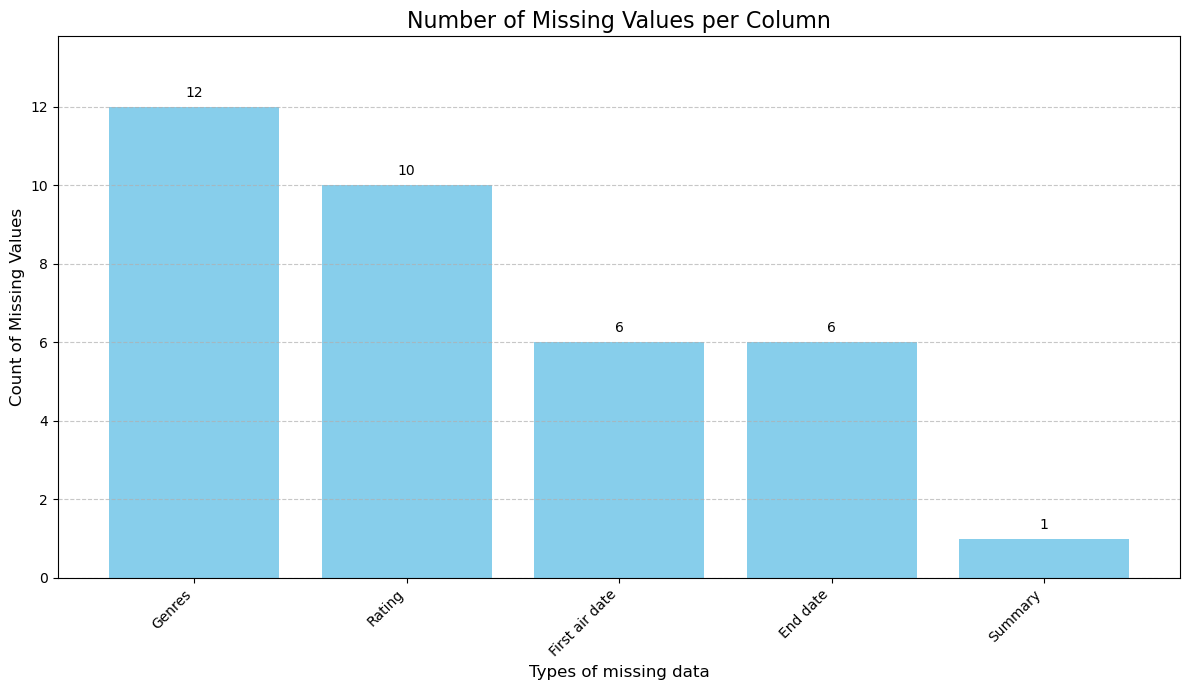

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Step 1: Count the missing values (NaN/None) per column ---
missing_counts = df.isnull().sum()

# Filter out columns with zero missing values for cleaner display
missing_data = missing_counts[missing_counts > 0].sort_values(ascending=False)

# --- Step 2: Display the analysis results ---
print("📊 Missing Value Analysis:")
print("-" * 50)

if missing_data.empty:
    print("Good news! There are no missing values (NaN/None) in any column.")
else:
    print("Missing counts per column (columns with 0 missing values are excluded):")
    print(missing_data.to_string())

    # --- Step 3: Visualize the results with a bar chart and labels ---

    columns = missing_data.index.tolist()
    counts = missing_data.values.tolist()

    fig, ax = plt.subplots(figsize=(12, 7)) 

    bars = ax.bar(columns, counts, color='skyblue')

    ax.bar_label(bars, fmt='%d', padding=5) 

    ax.set_title('Number of Missing Values per Column', fontsize=16)
    ax.set_xlabel('Types of missing data', fontsize=12)
    ax.set_ylabel('Count of Missing Values', fontsize=12)
    
    max_missing = missing_data.max()
    ax.set_ylim(0, max_missing * 1.15) 
    
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() 
    plt.show()

### Analysis

After checking the web pages to which the missing data belonged, it was not difficult to find that most of the missing data was because the content of this page was missing, such as https://www.tvmaze.com/shows/64950/visionquest. Because it has not been actually released, the ***rating*** or other elements do not exist.

## 2.2 Fundamental analysis of sample distribution

This helps us understand outliers, and feature distribution.

Total rows before handling missing 'First air date': 200
Total rows after handling missing 'First air date': 194
Total rows after date conversion cleaning: 194


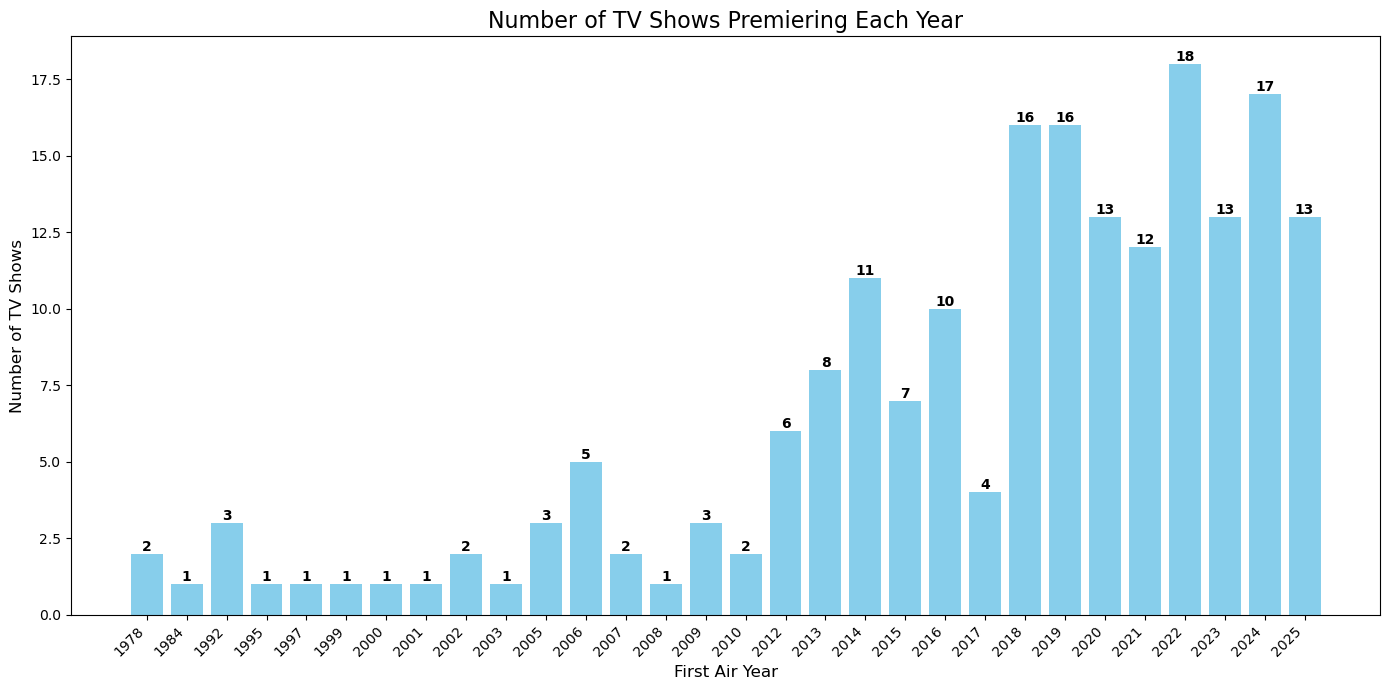


--- Summary of Yearly Premieres ---
    Year  Count
0   1978      2
1   1984      1
2   1992      3
3   1995      1
4   1997      1
5   1999      1
6   2000      1
7   2001      1
8   2002      2
9   2003      1
10  2005      3
11  2006      5
12  2007      2
13  2008      1
14  2009      3
15  2010      2
16  2012      6
17  2013      8
18  2014     11
19  2015      7
20  2016     10
21  2017      4
22  2018     16
23  2019     16
24  2020     13
25  2021     12
26  2022     18
27  2023     13
28  2024     17
29  2025     13


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preprocessing for the required analysis ---

# 1. Address Missing Values in 'First air date'
# For the purpose of counting shows by the year they first aired, 
# any row with a missing 'First air date' cannot be included in this specific analysis.
# We will drop these rows for this particular chart.

print(f"Total rows before handling missing 'First air date': {len(df)}")
df.dropna(subset=['First air date'], inplace=True)
print(f"Total rows after handling missing 'First air date': {len(df)}")

# 2. Extract the year from 'First air date'
# Convert the 'First air date' column to datetime objects
# The 'errors='coerce'' argument will turn any value that cannot be parsed into a date (like a non-standard date string) into NaT (Not a Time), 
# which is another way of handling 'missing' or 'invalid' data here.
df['First air date'] = pd.to_datetime(df['First air date'], errors='coerce')

# Drop any rows where the date conversion failed (now NaT)
df.dropna(subset=['First air date'], inplace=True)
print(f"Total rows after date conversion cleaning: {len(df)}")

# Extract the year
df['Start Year'] = df['First air date'].dt.year

# 3. Calculate the count of shows per year
# Count the occurrences of each year
yearly_counts = df['Start Year'].value_counts().sort_index()

# Convert the results to a DataFrame for easier plotting and display
yearly_counts_df = yearly_counts.reset_index()
yearly_counts_df.columns = ['Year', 'Count']

# --- Plotting the Bar Chart ---

plt.figure(figsize=(14, 7)) # Set the size of the plot
bars = plt.bar(yearly_counts_df['Year'].astype(str), yearly_counts_df['Count'], color='skyblue')

# Add labels and title
plt.title('Number of TV Shows Premiering Each Year', fontsize=16)
plt.xlabel('First Air Year', fontsize=12)
plt.ylabel('Number of TV Shows', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the count value on top of each bar
for bar in bars:
    yval = bar.get_height()
    # Add the text slightly above the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Ensure all elements fit in the figure
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Summary of Yearly Premieres ---")
print(yearly_counts_df)

### Analysis of ***Number of TV Shows Premiering Each Year***

It is obvious that the number of TV shows increases with the year (the dataset is ***randomly*** sampled from the web page, and there will be no duplication of the dataset caused by sampling from the first page)

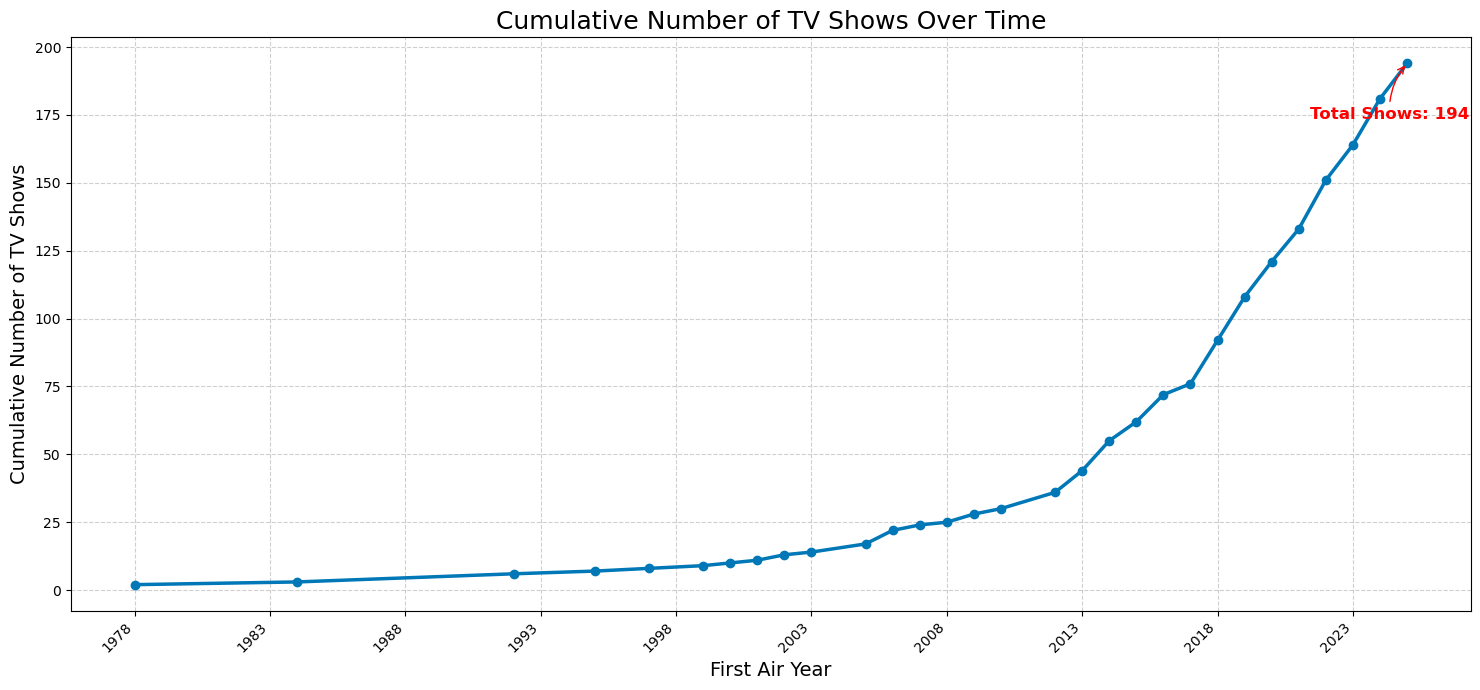


--- Summary of Cumulative Premieres ---
    Year  Count  Cumulative Count
20  2016     10                72
21  2017      4                76
22  2018     16                92
23  2019     16               108
24  2020     13               121
25  2021     12               133
26  2022     18               151
27  2023     13               164
28  2024     17               181
29  2025     13               194


In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in 'First air date'
# As before, we must have a start date to include the show in the timeline.
df.dropna(subset=['First air date'], inplace=True)

# 2. Extract the year
# Convert the 'First air date' column to datetime objects, coercing invalid dates to NaT
df['First air date'] = pd.to_datetime(df['First air date'], errors='coerce')

# Drop any rows where the date conversion failed (now NaT)
df.dropna(subset=['First air date'], inplace=True)

# Extract the year
df['Start Year'] = df['First air date'].dt.year

# 3. Calculate Yearly Counts and Sort by Year
# Count the occurrences of each year
yearly_counts = df['Start Year'].value_counts().sort_index()

# Convert to DataFrame for easier manipulation
yearly_counts_df = yearly_counts.reset_index()
yearly_counts_df.columns = ['Year', 'Count']

# 4. Calculate the Cumulative Sum (The Key Step)
# Use the 'cumsum()' function to calculate the running total of TV shows
yearly_counts_df['Cumulative Count'] = yearly_counts_df['Count'].cumsum()

# --- Plotting the Line Chart ---

plt.figure(figsize=(15, 7))

# Plot the cumulative count as a line chart
plt.plot(
    yearly_counts_df['Year'],
    yearly_counts_df['Cumulative Count'],
    marker='o',             # Use circles for data points
    linestyle='-',          # Solid line
    color='#0077b6',        # A distinct blue color
    linewidth=2.5,
    markersize=6
)

# Add labels and title
plt.title('Cumulative Number of TV Shows Over Time', fontsize=18)
plt.xlabel('First Air Year', fontsize=14)
plt.ylabel('Cumulative Number of TV Shows', fontsize=14)

# Add a grid for better readability of the trend
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight the final (total) count
final_year = yearly_counts_df['Year'].iloc[-1]
final_count = yearly_counts_df['Cumulative Count'].iloc[-1]
plt.annotate(
    f'Total Shows: {final_count}',
    xy=(final_year, final_count),
    xytext=(-70, -40),  # Offset text slightly
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='red'),
    fontsize=12,
    color='red',
    fontweight='bold'
)

# Customize X-axis ticks to show fewer labels for better clarity if the range is large
# We'll display every 5 years, for example
start_year = yearly_counts_df['Year'].min()
end_year = yearly_counts_df['Year'].max()
tick_interval = 5
xticks = range(start_year, end_year + 1, tick_interval)
plt.xticks(xticks, rotation=45, ha='right')

# Ensure layout is tight
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Summary of Cumulative Premieres ---")
print(yearly_counts_df.tail(10)) # Show the last 10 years of the trend

### Analysis of ***Cumulative Number of TV Shows Over Time***

It's not hard to see that the total number of TV shows has grown much **faster** since around *2017*. 

This may be because people are watching more TV shows on their phones and tablets rather than on traditional television, leading to a **boom** in the industry and more TV shows being produced and uploaded online. 

Another possible reason is that older TV shows may not be recorded on this website.

Total rows before cleaning 'First air date': 200
Total rows after date cleaning: 194


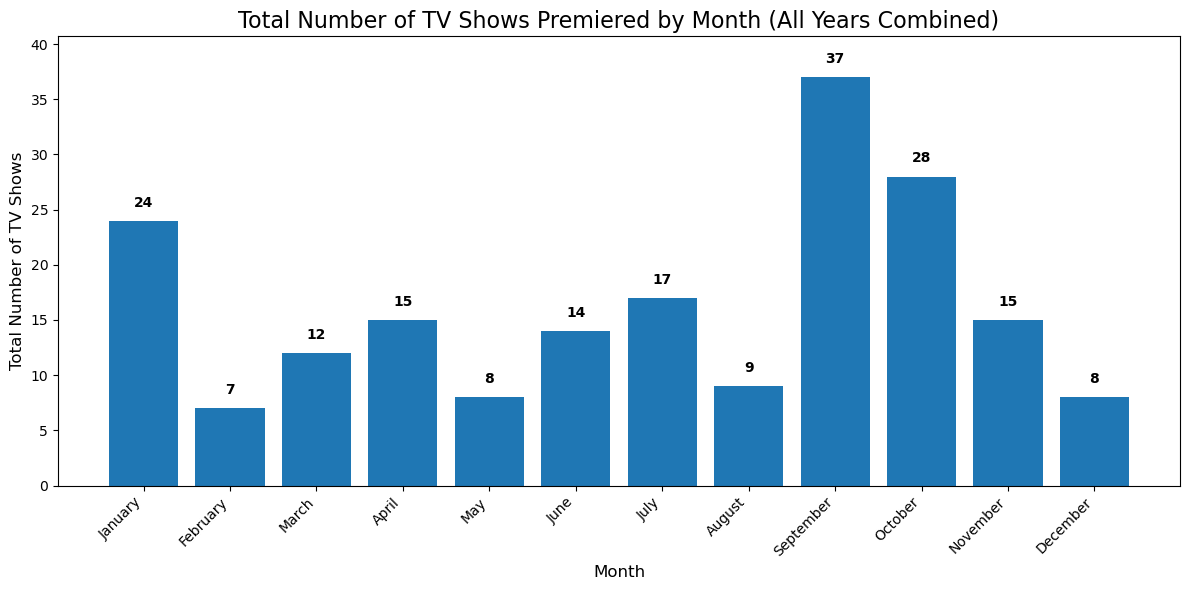


--- Summary of Monthly Premieres ---
   Month_Name  Count
0     January     24
1    February      7
2       March     12
3       April     15
4         May      8
5        June     14
6        July     17
7      August      9
8   September     37
9     October     28
10   November     15
11   December      8


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in 'First air date'
# We must have a 'First air date' to determine the premiere month.
# Dropping rows where this date is missing is the most appropriate way to handle this for this specific analysis.
print(f"Total rows before cleaning 'First air date': {len(df)}")
df.dropna(subset=['First air date'], inplace=True)

# 2. Convert to Datetime and Extract Month
# Convert the 'First air date' column to datetime objects
# The 'errors='coerce'' handles any non-standard date strings by turning them into NaT.
df['First air date'] = pd.to_datetime(df['First air date'], errors='coerce')

# Drop any rows where the date conversion failed (now NaT)
df.dropna(subset=['First air date'], inplace=True)
print(f"Total rows after date cleaning: {len(df)}")

# Extract the month number (1=January, 12=December)
df['Start Month'] = df['First air date'].dt.month

# 3. Calculate Total Count of Shows per Month
# Count the occurrences of each month and sort by the month number (index)
monthly_counts = df['Start Month'].value_counts().sort_index()

# Convert the results to a DataFrame for plotting
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month_Number', 'Count']

# 4. Map Month Numbers to Names for better chart readability
# Create a list of full month names in order
month_names = [calendar.month_name[i] for i in monthly_counts_df['Month_Number']]
monthly_counts_df['Month_Name'] = month_names

# --- Plotting the Bar Chart ---

plt.figure(figsize=(12, 6))

# Plot the data
bars = plt.bar(
    monthly_counts_df['Month_Name'],
    monthly_counts_df['Count'],
    color='#1f77b4'  # A standard blue color
)

# Add labels and title
plt.title('Total Number of TV Shows Premiered by Month (All Years Combined)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Number of TV Shows', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add the count value on top of each bar (Annotation)
for bar in bars:
    yval = bar.get_height()
    # Add the text slightly above the bar, centered
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 1,  # Add a small buffer (e.g., 5) for better spacing
        int(yval),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Adjust y-axis limit to ensure the numbers on top of bars are visible
plt.ylim(0, monthly_counts_df['Count'].max() * 1.1)

# Ensure all elements fit in the figure
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Summary of Monthly Premieres ---")
print(monthly_counts_df[['Month_Name', 'Count']])

### Analysis of ***Total Number of TV Shows Premiered by Month***

It can be seen that most TV shows tend to be first broadcasted in September or January.

Total rows before cleaning 'Genres' column: 200
Total rows after cleaning 'Genres' column: 188


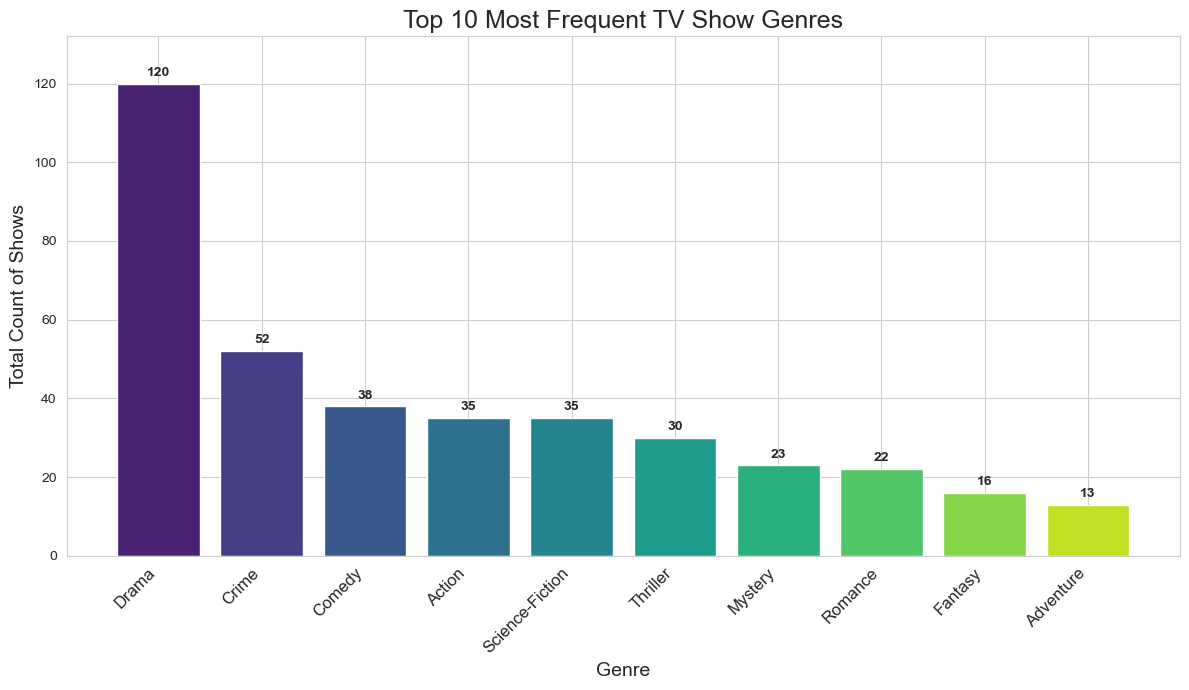


--- Top 10 Most Frequent Genres ---
              Genre  Count
7             Drama    120
0             Crime     52
2            Comedy     38
6            Action     35
8   Science-Fiction     35
1          Thriller     30
14          Mystery     23
13          Romance     22
15          Fantasy     16
9         Adventure     13


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set a clean plotting style
sns.set_style("whitegrid")

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in the 'Genres' column
# Shows with missing 'Genres' cannot contribute to the genre count, so we drop them for this analysis.
print(f"Total rows before cleaning 'Genres' column: {len(df)}")
df.dropna(subset=['Genres'], inplace=True)
print(f"Total rows after cleaning 'Genres' column: {len(df)}")

# 2. Split and Aggregate all Genres
all_genres = []

# Iterate over the 'Genres' column
for genres_str in df['Genres']:
    # Split the string by comma and remove leading/trailing whitespace
    genres_list = [genre.strip() for genre in genres_str.split(',')]
    all_genres.extend(genres_list)

# Use Counter to count the frequency of each individual genre
genre_counts = Counter(all_genres)

# Convert to DataFrame and sort to find the Top 10
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])
genre_df.sort_values(by='Count', ascending=False, inplace=True)

# Select the top 10 genres
top_10_genres = genre_df.head(10)

# --- Plotting the Bar Chart ---

plt.figure(figsize=(12, 7))

# Create the bar plot
bars = plt.bar(
    top_10_genres['Genre'],
    top_10_genres['Count'],
    color=sns.color_palette("viridis", 10)  # Use a nice color palette
)

# Add labels and title
plt.title('Top 10 Most Frequent TV Show Genres', fontsize=18)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Total Count of Shows', fontsize=14)

# Rotate X-axis labels for better fit
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add the count value on top of each bar (Annotation)
for bar in bars:
    yval = bar.get_height()
    # Add the text slightly above the bar, centered
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + (top_10_genres['Count'].max() * 0.01), # Dynamic vertical offset
        int(yval),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Adjust y-axis limit to ensure the numbers on top of bars are visible
plt.ylim(0, top_10_genres['Count'].max() * 1.1)

# Ensure layout is tight
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Top 10 Most Frequent Genres ---")
print(top_10_genres)

### Analysis of ***Top 10 Most Frequent TV Show Genres***

***Drama*** lead the pack, followed by ***Crime***.

This may be because viewers tend to prefer drama-themed TV shows because they offer dramatic plot twists and turns, which keep people entertained.

Total rows before cleaning 'Genres' column: 200
Total rows after cleaning 'Genres' column: 188


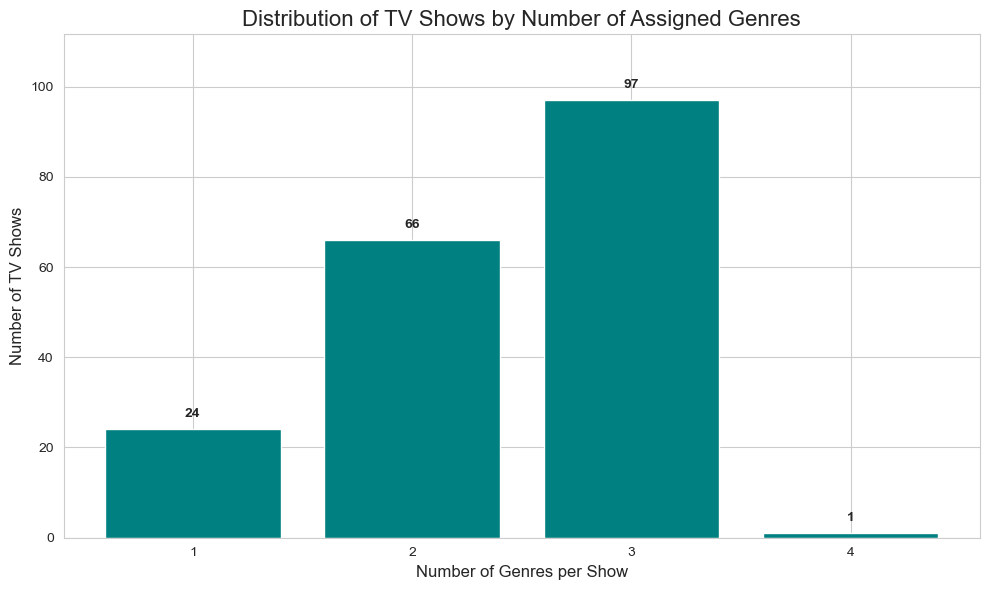


--- Summary of Genre Count Distribution ---
   Num_Genres  Show_Count
0           1          24
1           2          66
2           3          97
3           4           1


In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in the 'Genres' column
# We need the 'Genres' column to calculate the number of genres. 
# Rows with missing 'Genres' are excluded from this specific count.
print(f"Total rows before cleaning 'Genres' column: {len(df)}")
df_clean = df.dropna(subset=['Genres']).copy()
print(f"Total rows after cleaning 'Genres' column: {len(df_clean)}")

# 2. Calculate the Number of Genres per Show
# The genres are comma-separated strings (e.g., "Crime, Drama, Thriller").
# The number of genres is the number of commas + 1.

# Use a lambda function to count the number of genres:
# a) Check if the string is empty or just whitespace (already handled by dropna, but good practice)
# b) Split by comma, strip whitespace, and count the resulting list length.
def count_genres(genres_str):
    if not genres_str:
        return 0
    # Split the string by comma and remove leading/trailing whitespace
    genre_list = [g.strip() for g in genres_str.split(',') if g.strip()]
    return len(genre_list)

df_clean['Number of Genres'] = df_clean['Genres'].apply(count_genres)

# 3. Calculate the Frequency of Each Genre Count
# Group by the calculated 'Number of Genres' and count the shows in each group.
genre_count_distribution = df_clean['Number of Genres'].value_counts().sort_index()

# Convert to DataFrame for plotting
distribution_df = genre_count_distribution.reset_index()
distribution_df.columns = ['Num_Genres', 'Show_Count']

# Exclude 0 genres, although it should be minimal/zero after dropna
distribution_df = distribution_df[distribution_df['Num_Genres'] > 0]

# --- Plotting the Bar Chart ---

plt.figure(figsize=(10, 6))

# Create the bar plot
# Convert Num_Genres to string for correct categorical x-axis plotting
x_labels = distribution_df['Num_Genres'].astype(str)
bars = plt.bar(
    x_labels,
    distribution_df['Show_Count'],
    color='teal'
)

# Add labels and title
plt.title('Distribution of TV Shows by Number of Assigned Genres', fontsize=16)
plt.xlabel('Number of Genres per Show', fontsize=12)
plt.ylabel('Number of TV Shows', fontsize=12)

# Add the count value on top of each bar (Annotation)
for bar in bars:
    yval = bar.get_height()
    # Add the text slightly above the bar, centered
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 2,  # Add a small vertical offset
        int(yval),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Adjust y-axis limit
plt.ylim(0, distribution_df['Show_Count'].max() * 1.15)
plt.xticks(fontsize=10)

# Ensure layout is tight
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Summary of Genre Count Distribution ---")
print(distribution_df)

### Analysis of ***Distribution of TV Shows by Number of Assigned Genres***

TV shows with ***two or three*** genres make up the vast majority of viewers.

Fun fact: The only TV show with four genres in my .csv file is titled ***XL Joushi***. The four genres are **Adult, Anime, Comedy, and Romance**, and it only has a **5.6** rating.

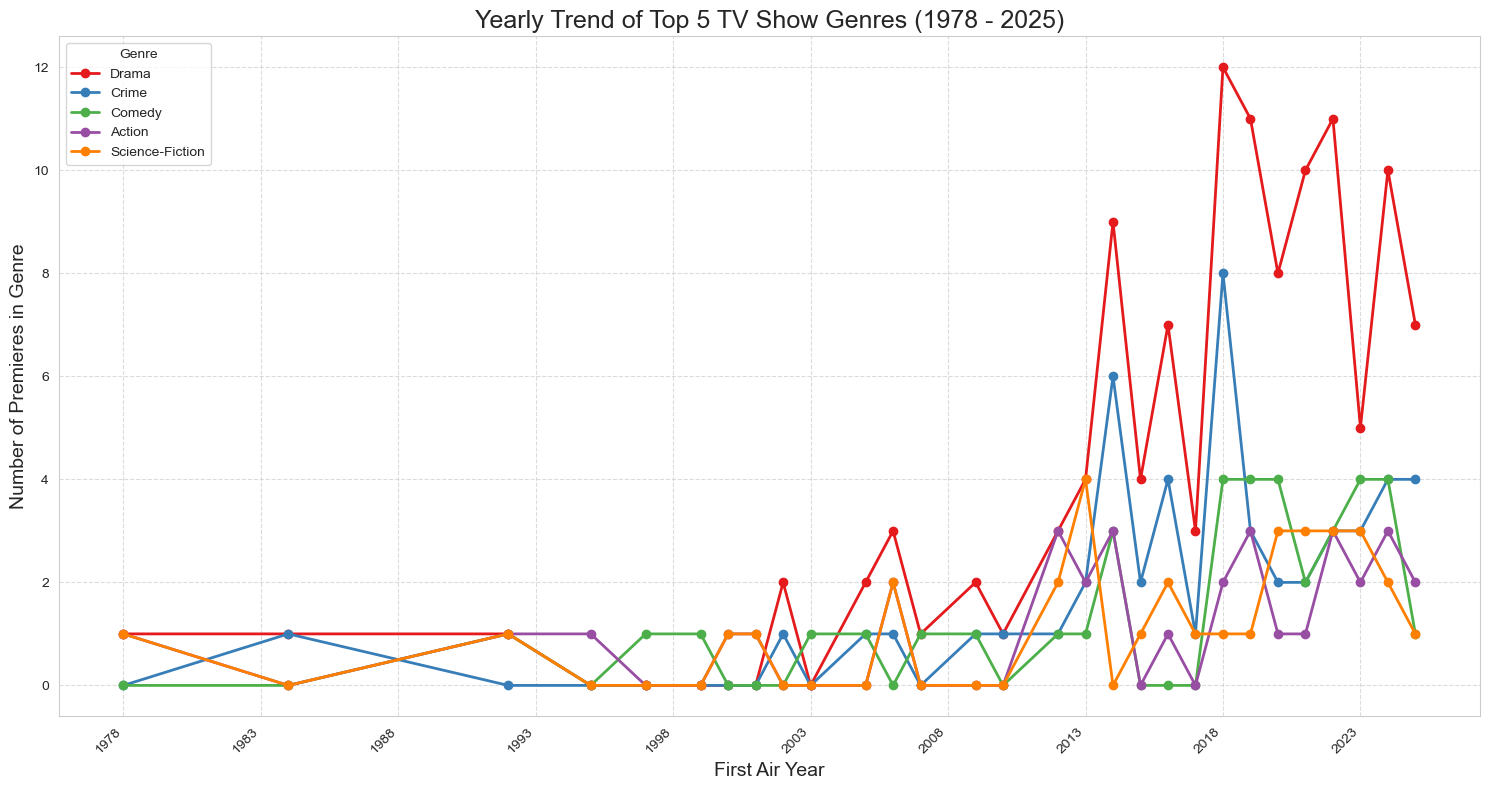


--- Summary of Yearly Genre Counts (Last 10 Years) ---
    Year  Drama  Crime  Comedy  Action  Science-Fiction
19  2016      7      4       0       1                2
20  2017      3      1       0       0                1
21  2018     12      8       4       2                1
22  2019     11      3       4       3                1
23  2020      8      2       4       1                3
24  2021     10      2       2       1                3
25  2022     11      3       3       3                3
26  2023      5      3       4       2                3
27  2024     10      4       4       3                2
28  2025      7      4       1       2                1


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the target genres you want to track
TARGET_GENRES = ['Drama', 'Crime', 'Comedy', 'Action', 'Science-Fiction']

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in key columns
# We need 'First air date' to determine the year and 'Genres' to categorize the show.
df_clean = df.dropna(subset=['First air date', 'Genres']).copy()

# 2. Extract Year and Convert Dates
df_clean['First air date'] = pd.to_datetime(df_clean['First air date'], errors='coerce')
df_clean.dropna(subset=['First air date'], inplace=True)
df_clean['Year'] = df_clean['First air date'].dt.year

# 3. Create a helper function for genre splitting and tagging
def genre_split_and_check(row, genre):
    """Checks if a show belongs to a specific genre."""
    # Ensure all genres are stripped of whitespace before checking
    if pd.isna(row['Genres']):
        return 0
    genres_list = [g.strip() for g in row['Genres'].split(',')]
    return 1 if genre in genres_list else 0

# 4. Create one-hot columns for the 5 target genres
for genre in TARGET_GENRES:
    df_clean[genre] = df_clean.apply(lambda row: genre_split_and_check(row, genre), axis=1)

# 5. Aggregate the counts by Year
# Group by 'Year' and sum the counts for each of the 5 genre columns
yearly_genre_counts = df_clean.groupby('Year')[TARGET_GENRES].sum()

# Reset index to make 'Year' a regular column
yearly_genre_counts = yearly_genre_counts.reset_index()

# Filter out years with very few shows for better trend visibility (optional but recommended)
# Here we keep only years that have at least one show in one of the top 5 genres
yearly_genre_counts = yearly_genre_counts[(yearly_genre_counts[TARGET_GENRES].sum(axis=1) > 0)]

# --- Plotting the Line Chart for Trend Analysis ---

plt.figure(figsize=(15, 8))

# Define a distinct color palette
colors = sns.color_palette("Set1", n_colors=len(TARGET_GENRES))

# Plot each genre's trend
for i, genre in enumerate(TARGET_GENRES):
    plt.plot(
        yearly_genre_counts['Year'],
        yearly_genre_counts[genre],
        label=genre,
        marker='o',  # Use markers to show individual data points
        linestyle='-',
        linewidth=2,
        markersize=6,
        color=colors[i]
    )

# Add labels and title
plt.title(f'Yearly Trend of Top 5 TV Show Genres ({yearly_genre_counts["Year"].min()} - {yearly_genre_counts["Year"].max()})', fontsize=18)
plt.xlabel('First Air Year', fontsize=14)
plt.ylabel('Number of Premieres in Genre', fontsize=14)

# Add legend to distinguish the lines
plt.legend(title='Genre', loc='upper left', fontsize=10)

# Customize X-axis ticks (showing every 5 years for readability)
start_year = yearly_genre_counts['Year'].min()
end_year = yearly_genre_counts['Year'].max()
tick_interval = 5
xticks = range(start_year, end_year + 1, tick_interval)
plt.xticks(xticks, rotation=45, ha='right', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Summary of Yearly Genre Counts (Last 10 Years) ---")
print(yearly_genre_counts.tail(10))

### Analysis of ***Yearly Trend of Top 5 TV Show Genres***

Intuitively, ***Drama***, the top-ranked genre, and ***Crime***, the top-ranked genre, have maintained their respective leading positions year after year.

In contrast, ***Science-Fiction***, the last genre on the top list, has maintained a relatively stable number of views.

Total rows before cleaning 'Status' column: 200
Total rows after cleaning 'Status' column: 200


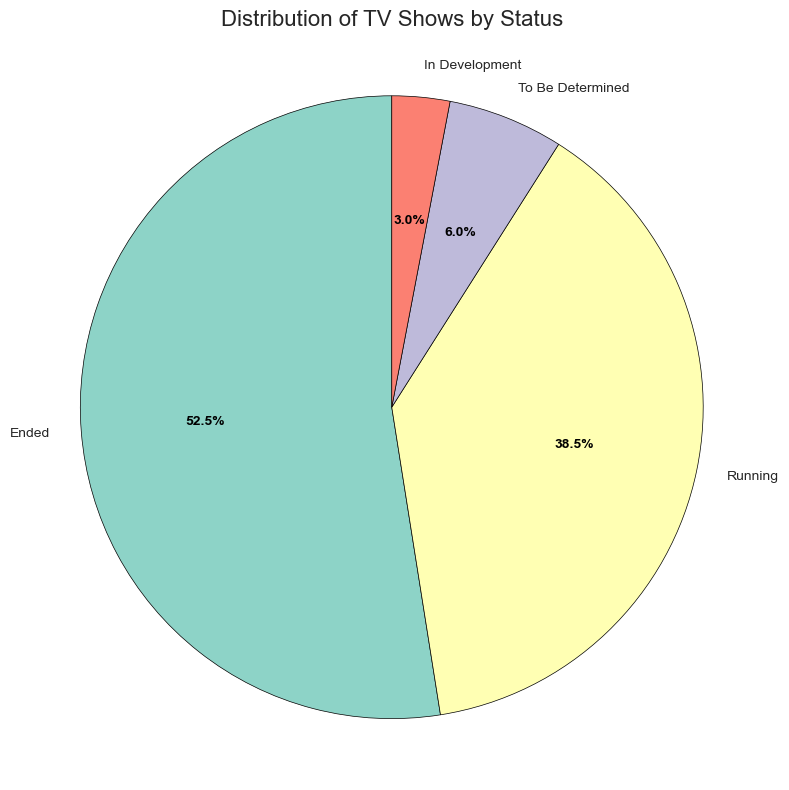


--- Summary of TV Show Status Distribution ---
             Status  Percentage
0             Ended        52.5
1           Running        38.5
2  To Be Determined         6.0
3    In Development         3.0


In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in the 'Status' column
# Shows with missing 'Status' cannot be categorized. For a total distribution pie chart, 
# we can treat missing values as an "Unknown" category or drop them. 
# We will drop them to focus on known statuses, as the request is for the distribution of 'Status'.
print(f"Total rows before cleaning 'Status' column: {len(df)}")
df_clean = df.dropna(subset=['Status']).copy()
print(f"Total rows after cleaning 'Status' column: {len(df_clean)}")

# 2. Calculate the count and proportion for each status
status_counts = df_clean['Status'].value_counts()
status_proportions = status_counts / status_counts.sum() * 100

# Convert to DataFrame for easier inspection
status_df = status_proportions.reset_index()
status_df.columns = ['Status', 'Percentage']

# --- Plotting the Pie Chart ---

# Set figure size for better visual
plt.figure(figsize=(8, 8))

# Define the colors for the slices (optional, but improves aesthetics)
# Use a palette that works well for categorical data
colors = plt.cm.Set3.colors 

# Create the pie chart
# autopct='%1.1f%%' formats the percentage label to one decimal place
# startangle=90 starts the first slice at the top
# wedgeprops={'edgecolor': 'black'} adds borders to slices
wedges, texts, autotexts = plt.pie(
    status_counts, 
    labels=status_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 10}
)

# Customize the text inside the slices for better visibility
# This ensures the percentage labels are distinct and bold
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')
    autotext.set_fontsize(10)

# Add a title
plt.title('Distribution of TV Shows by Status', fontsize=16)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal') 

# Ensure layout is tight
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Summary of TV Show Status Distribution ---")
print(status_df)

### Analysis of ***Distribution of TV Shows by Status***

Honestly, I wasn't expecting so many shows to be in the ***Running*** status. I assumed that most TV shows would have already ***Ended*** due to the time span.

A possible explanation is that most TV shows started airing in recent years, so many are still in the ***Running*** status.

Total rows before cleaning 'Network or Channel': 200
Total rows after cleaning 'Network or Channel': 200


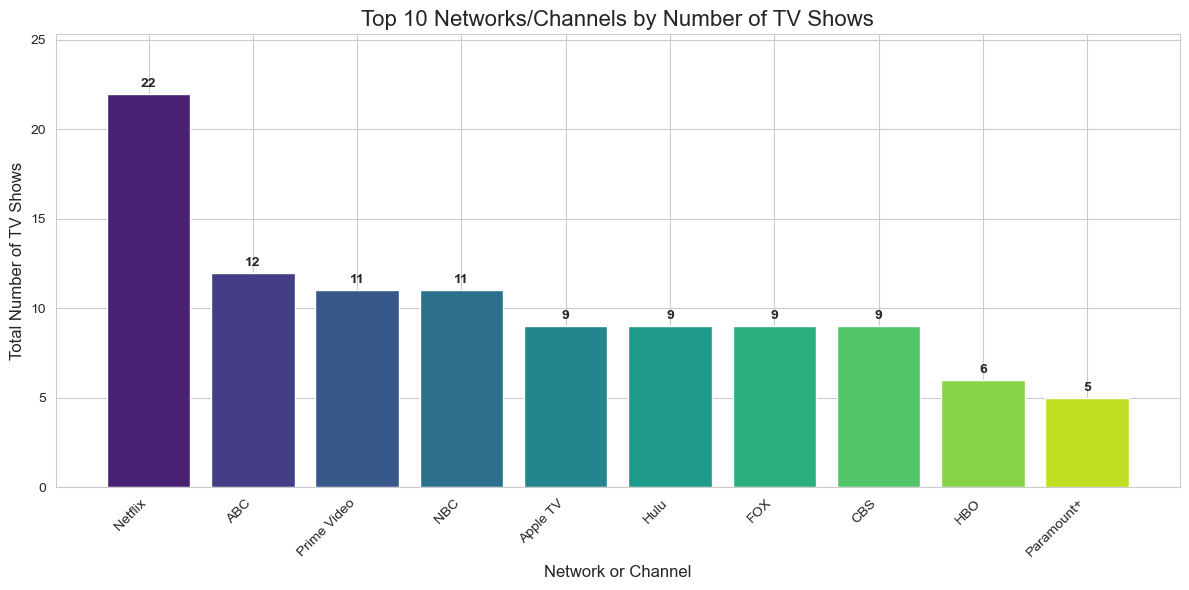


--- Top 10 Networks/Channels Summary ---
       Network  Show_Count
0      Netflix          22
1          ABC          12
2  Prime Video          11
3          NBC          11
4     Apple TV           9
5         Hulu           9
6          FOX           9
7          CBS           9
8          HBO           6
9   Paramount+           5


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_id = "Zichen Qiu_2252705.csv"
df = pd.read_csv(file_id)

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in the 'Network or Channel' column
# We need this column to count the distribution. Rows with missing data are dropped for this analysis.
print(f"Total rows before cleaning 'Network or Channel': {len(df)}")
df_clean = df.dropna(subset=['Network or Channel']).copy()
print(f"Total rows after cleaning 'Network or Channel': {len(df_clean)}")

# 2. Clean the Network/Channel names (optional but good practice)
# Ensure consistent capitalization and remove extra spaces if any were missed
df_clean['Network or Channel'] = df_clean['Network or Channel'].str.strip()

# 3. Calculate the count for each Network/Channel
network_counts = df_clean['Network or Channel'].value_counts()

# 4. Select the Top 10 Networks/Channels
top_10_networks = network_counts.head(10).reset_index()
top_10_networks.columns = ['Network', 'Show_Count']

# --- Plotting the Bar Chart ---

plt.figure(figsize=(12, 6))

# Use Seaborn's color palette for distinct bars
sns.set_palette("tab10") 

# Create the bar plot
# We plot the Network names on the X-axis and the Show_Count on the Y-axis
bars = plt.bar(
    top_10_networks['Network'],
    top_10_networks['Show_Count'],
    color=sns.color_palette("viridis", 10) # Use a good contrasting palette
)

# Add labels and title
plt.title('Top 10 Networks/Channels by Number of TV Shows', fontsize=16)
plt.xlabel('Network or Channel', fontsize=12)
plt.ylabel('Total Number of TV Shows', fontsize=12)

# Rotate X-axis labels for better fit
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add the count value on top of each bar (Annotation)
for bar in bars:
    yval = bar.get_height()
    # Add the text slightly above the bar, centered
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + (top_10_networks['Show_Count'].max() * 0.01), # Dynamic vertical offset
        int(yval),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Adjust y-axis limit to ensure the numbers on top of bars are visible
plt.ylim(0, top_10_networks['Show_Count'].max() * 1.15)

# Ensure layout is tight
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Top 10 Networks/Channels Summary ---")
print(top_10_networks)

### Analysis of ***Top 10 Networks/Channels by Number of TV Shows***

As expected, ***Netflix*** took first place with a clear advantage in viewership.

The explanation is simple: the majority of TV shows tend to be broadcast on ***Netflix***, a habit that has long been a staple for most viewers.

## 2.3 Connections between statistics

Try to find possible relationships between two elements.

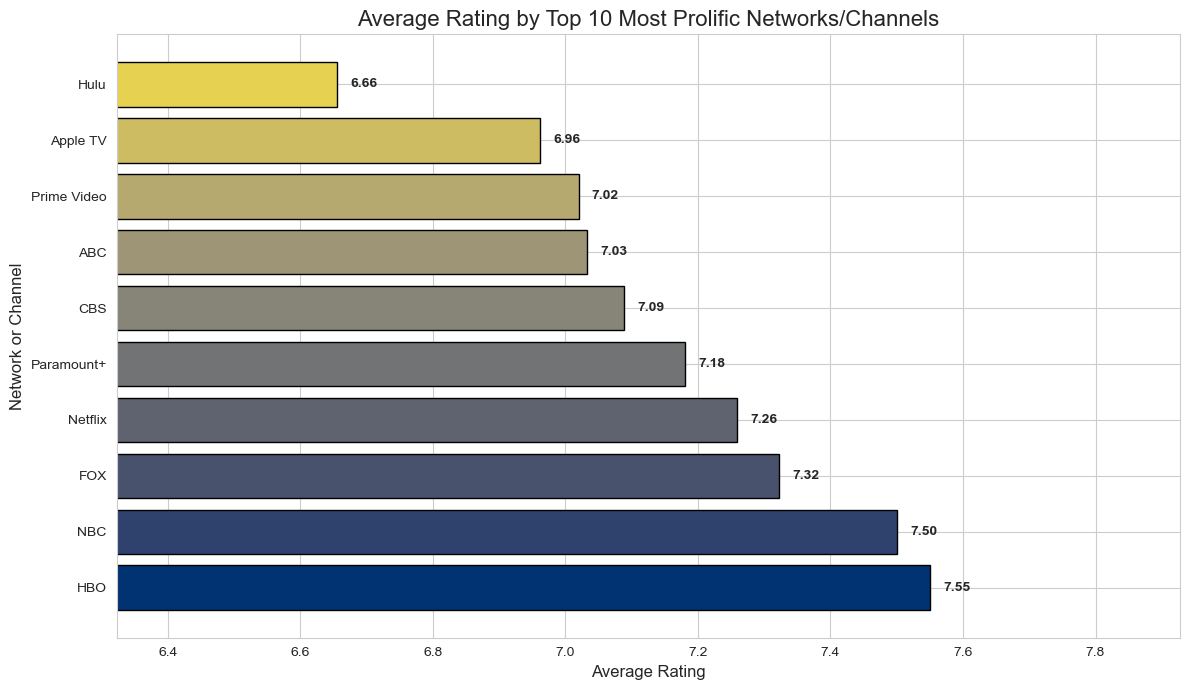


--- Summary of Average Ratings for Top 10 Networks ---
       Network  Average_Rating
0          HBO        7.550000
1          NBC        7.500000
2          FOX        7.322222
3      Netflix        7.259091
4   Paramount+        7.180000
5          CBS        7.088889
6          ABC        7.033333
7  Prime Video        7.020000
8     Apple TV        6.962500
9         Hulu        6.655556


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('Zichen Qiu_2252705.csv')
except FileNotFoundError:
    print("Error: The file 'Zichen Qiu_2252705.csv' was not found.")
    raise

# --- Data Cleaning and Preparation ---

# 1. Identify the Top 10 Networks (Replicating the previous step)
# Drop rows where Network is missing to ensure a clean count
df_network_clean = df.dropna(subset=['Network or Channel']).copy()
top_10_networks_list = df_network_clean['Network or Channel'].value_counts().head(10).index.tolist()

# 2. Handle Missing Ratings
# Drop rows where Rating is missing, as we cannot calculate the average rating without it.
# Convert 'Rating' to a numeric type, coercing non-numeric values (if any) to NaN, then drop those NaNs.
df_clean = df.dropna(subset=['Rating']).copy()
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
df_clean.dropna(subset=['Rating'], inplace=True)

# 3. Filter the data to include ONLY the Top 10 Networks/Channels
df_top_networks = df_clean[df_clean['Network or Channel'].isin(top_10_networks_list)].copy()

# 4. Calculate the Average Rating for each of the Top 10 Networks
average_ratings = df_top_networks.groupby('Network or Channel')['Rating'].mean().sort_values(ascending=False)

# Convert to DataFrame for plotting
average_ratings_df = average_ratings.reset_index()
average_ratings_df.columns = ['Network', 'Average_Rating']

# --- Plotting the Bar Chart ---

plt.figure(figsize=(12, 7))

# Create the bar plot (Horizontal bar chart is often better for long category names)
# We use Horizontal bar chart (barh) to improve network label readability.
bars = plt.barh(
    average_ratings_df['Network'],
    average_ratings_df['Average_Rating'],
    color=sns.color_palette("cividis", len(average_ratings_df)), # Distinct color palette
    edgecolor='black'
)

# Set the title and labels
plt.title('Average Rating by Top 10 Most Prolific Networks/Channels', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Network or Channel', fontsize=12)

# Set X-axis limit to focus on the common rating range (e.g., 6.0 to 9.0)
# Adjust the min limit based on your data's actual lowest rating
min_rating = average_ratings_df['Average_Rating'].min() * 0.95
plt.xlim(min_rating, average_ratings_df['Average_Rating'].max() * 1.05)


# Add the average rating value on the right side of each bar (Annotation)
for bar in bars:
    # Use bar.get_width() for horizontal bar height (which is the rating value)
    xval = bar.get_width()
    yval = bar.get_y() + bar.get_height()/2 # Center text vertically
    
    # Format the rating to two decimal places
    rating_text = f'{xval:.2f}'
    
    # Place text just past the end of the bar
    plt.text(
        xval + 0.02, # Adjust horizontal offset (0.02 is a small margin)
        yval,
        rating_text,
        ha='left',
        va='center',
        fontsize=10,
        fontweight='bold'
    )

# Ensure layout is tight
plt.tight_layout()

# Display the chart
plt.show()

print("\n--- Summary of Average Ratings for Top 10 Networks ---")
print(average_ratings_df)

### Analysis of ***Average Rating by Top 10 Most Prolific Networks/Channels***

This is where things get interesting: ***HBO*** is the network/channel with the highest average rating, while ***Netflix***, the most popular, has an average rating of 7.259.

This may indicate that higher-quality TV shows aren't necessarily the most popular.

Total shows used in analysis: 190
Status categories analyzed: ['Ended', 'Running', 'To Be Determined']


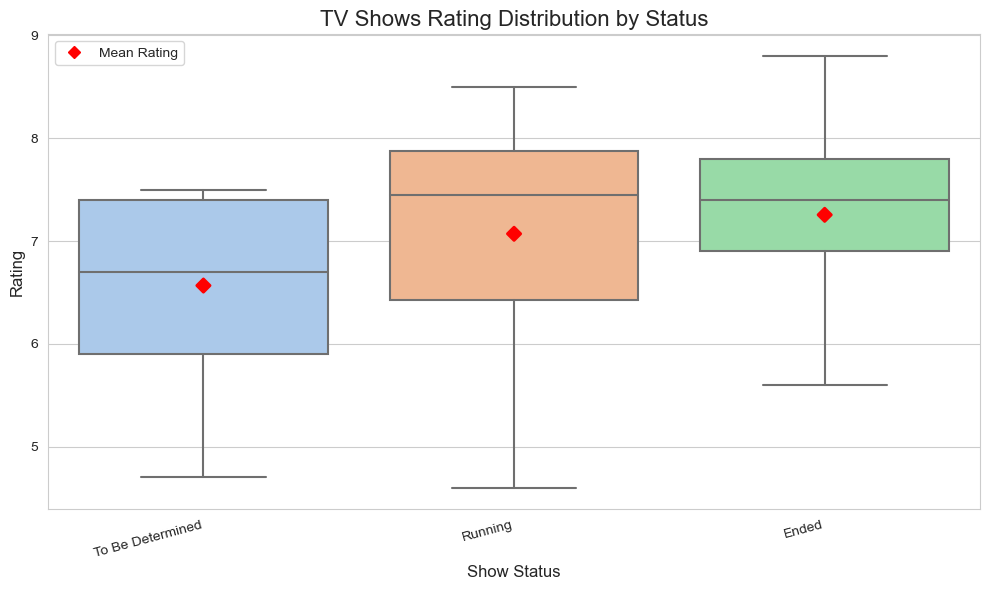


--- Summary: Mean Rating by Status ---
Status
Ended               7.25
Running             7.07
To Be Determined    6.57
Name: Rating, dtype: float64


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean plotting style
sns.set_style("whitegrid")

# Load the dataset
try:
    df = pd.read_csv('Zichen Qiu_2252705.csv')
except FileNotFoundError:
    print("Error: The file 'Zichen Qiu_2252705.csv' was not found.")
    raise

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in key columns
# We need both 'Rating' and 'Status' to perform this analysis.
df_clean = df.dropna(subset=['Rating', 'Status']).copy()

# 2. Convert 'Rating' to Numeric
# Convert 'Rating' to a numeric type, coercing any non-standard entries to NaN,
# and then drop those NaNs.
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
df_clean.dropna(subset=['Rating'], inplace=True)

# 3. Clean the Status names (optional)
df_clean['Status'] = df_clean['Status'].str.strip()

# Filter out statuses with too few shows (e.g., fewer than 2) for stable statistics
status_counts = df_clean['Status'].value_counts()
valid_statuses = status_counts[status_counts >= 2].index
df_filtered = df_clean[df_clean['Status'].isin(valid_statuses)]

print(f"Total shows used in analysis: {len(df_filtered)}")
print(f"Status categories analyzed: {valid_statuses.tolist()}")

# --- Plotting the Box Plot ---

plt.figure(figsize=(10, 6))

# Create the Box Plot using Seaborn
# x='Status' defines the categories on the X-axis
# y='Rating' defines the quantitative distribution on the Y-axis
sns.boxplot(
    x='Status',
    y='Rating',
    data=df_filtered,
    palette='pastel',  # Use a gentle color palette
    whis=1.5,          # Standard whisker length (1.5 * IQR)
    showfliers=False   # Hide individual outliers for a cleaner look (optional)
)

# Overlay the mean rating for better comparison (optional)
sns.pointplot(
    x='Status',
    y='Rating',
    data=df_filtered,
    color='red',
    linestyles='none',
    markers='D',  # Diamond marker for the mean
    errorbar=None, # Only show the mean point
    capsize=0.1
)

# Add labels and title
plt.title('TV Shows Rating Distribution by Status', fontsize=16)
plt.xlabel('Show Status', fontsize=12)
plt.ylabel('Rating', fontsize=12)

# Rotate X-axis labels for better fit if status names are long
plt.xticks(rotation=15, ha='right')

# Add a legend for the mean marker
plt.plot([], [], 'D', color='red', label='Mean Rating')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# --- Summary of Mean Ratings ---
mean_ratings = df_filtered.groupby('Status')['Rating'].mean().sort_values(ascending=False)
print("\n--- Summary: Mean Rating by Status ---")
print(mean_ratings.round(2))

### Analysis of ***TV Shows Rating Distribution by Status***

As you can see, the average score for ***Ended*** is slightly higher than that for ***Running***, and both are significantly ahead of ***To Be Determined***.

In terms of distribution, the variance for ***Ended*** is smaller, indicating a more concentrated distribution of ***Ratings***. The variance for the other two categories is significantly larger.

Also, half of the TV shows in the ***Running*** status received very high scores, perhaps due to viewers' continued anticipation for these shows, as they haven't concluded yet.

Total entries (show-genre pairings) used in analysis: 270


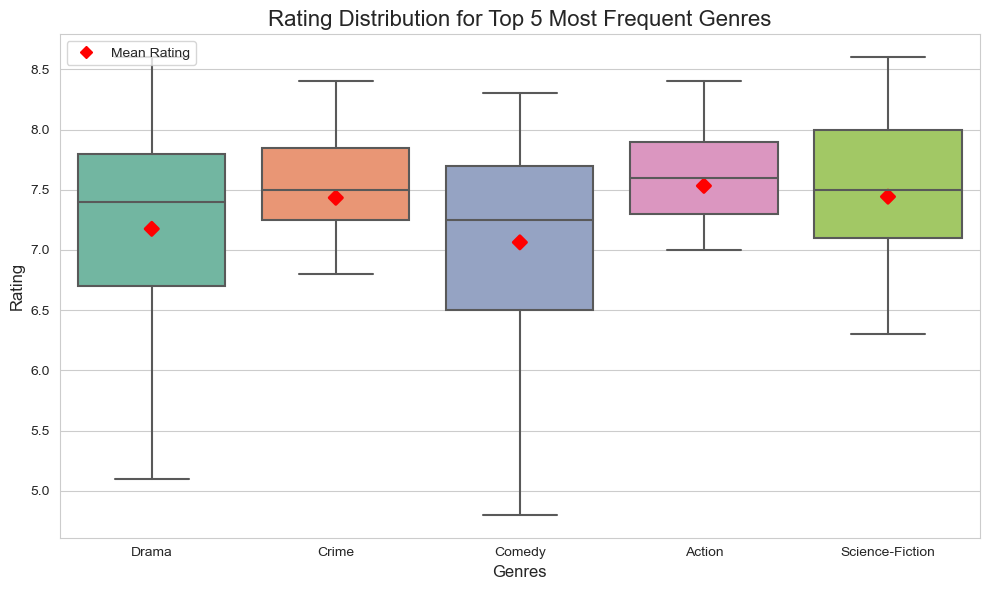


--- Summary: Mean Rating by Genre ---
Genre
Action             7.53
Science-Fiction    7.44
Crime              7.43
Drama              7.18
Comedy             7.06
Name: Rating, dtype: float64


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean plotting style
sns.set_style("whitegrid")

# Define the target genres (Assuming these are the top 5, based on prior context/common sense)
TARGET_GENRES = ['Drama', 'Crime', 'Comedy', 'Action', 'Science-Fiction'] 

# Load the dataset
try:
    df = pd.read_csv('Zichen Qiu_2252705.csv')
except FileNotFoundError:
    print("Error: The file 'Zichen Qiu_2252705.csv' was not found.")
    raise

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in key columns
# We need 'Rating' and 'Genres' to perform this analysis.
df_clean = df.dropna(subset=['Rating', 'Genres']).copy()

# 2. Convert 'Rating' to Numeric
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
df_clean.dropna(subset=['Rating'], inplace=True)

# 3. Create a helper function for genre splitting and tagging
def genre_split_and_check(row, genre):
    """Checks if a show belongs to a specific genre."""
    if pd.isna(row['Genres']):
        return 0
    # Split, strip whitespace, and check for the genre
    genres_list = [g.strip() for g in row['Genres'].split(',')]
    return 1 if genre in genres_list else 0

# 4. Create one-hot columns for the 5 target genres
for genre in TARGET_GENRES:
    df_clean[genre] = df_clean.apply(lambda row: genre_split_and_check(row, genre), axis=1)

# 5. Restructure Data for Seaborn Plotting (Melting)
# We need to transform the data from wide format (one column per genre) to long format (one row per show-genre combination)
# Filter only rows where the show belongs to one of the target genres (value == 1)
df_genre_ratings = pd.melt(
    df_clean,
    id_vars=['Rating'],
    value_vars=TARGET_GENRES,
    var_name='Genre',
    value_name='Is_Member'
)

# Keep only the rows where Is_Member is 1 (the show belongs to that genre)
df_plot = df_genre_ratings[df_genre_ratings['Is_Member'] == 1].copy()

print(f"Total entries (show-genre pairings) used in analysis: {len(df_plot)}")

# --- Plotting the Box Plot ---

plt.figure(figsize=(10, 6))

# Create the Box Plot using Seaborn
# x='Genre' defines the categories on the X-axis
# y='Rating' defines the quantitative distribution on the Y-axis
sns.boxplot(
    x='Genre',
    y='Rating',
    data=df_plot,
    palette='Set2',  # Use a distinct color palette
    whis=1.5,
    showfliers=False # Hide individual outliers for a cleaner look (optional)
)

# Overlay the mean rating for better comparison
sns.pointplot(
    x='Genre',
    y='Rating',
    data=df_plot,
    color='red',
    linestyles='none',
    markers='D',  # Diamond marker for the mean
    errorbar=None, 
    capsize=0.1
)

# Add labels and title
plt.title('Rating Distribution for Top 5 Most Frequent Genres', fontsize=16)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Rating', fontsize=12)

# Add a legend for the mean marker
plt.plot([], [], 'D', color='red', label='Mean Rating')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# --- Summary of Mean Ratings ---
mean_ratings = df_plot.groupby('Genre')['Rating'].mean().sort_values(ascending=False)
print("\n--- Summary: Mean Rating by Genre ---")
print(mean_ratings.round(2))

### Analysis of ***Rating Distribution for Top 5 Most Frequent Genres***

As the chart shows, the ***Crime*** and ***Action*** categories not only have high average ratings but also very low variance. This suggests that TV shows in these two genres are generally well-received and lack particularly poor ratings.

In contrast, the average rating for ***Drama***, which is relatively popular, is lower.

Analyzing average rating trend from 2006 to 2025


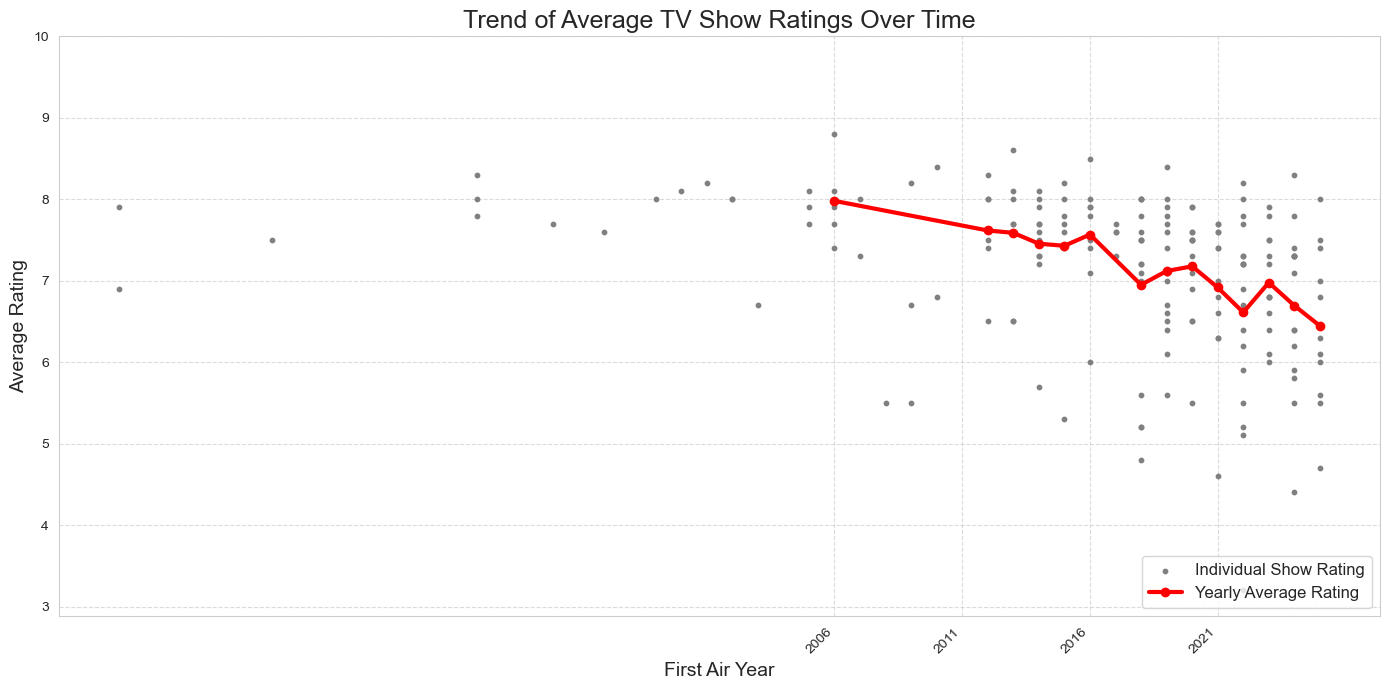


--- Summary: Yearly Average Ratings (Last 10 Years) ---
    Year  Rating
19  2015    7.43
20  2016    7.57
22  2018    6.95
23  2019    7.12
24  2020    7.18
25  2021    6.92
26  2022    6.61
27  2023    6.98
28  2024    6.69
29  2025    6.45


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean plotting style
sns.set_style("whitegrid")

# Load the dataset
try:
    df = pd.read_csv('Zichen Qiu_2252705.csv')
except FileNotFoundError:
    print("Error: The file 'Zichen Qiu_2252705.csv' was not found.")
    raise

# --- Data Cleaning and Preparation ---

# 1. Handle Missing Values in key columns
# We need 'Rating' and 'First air date'
df_clean = df.dropna(subset=['Rating', 'First air date']).copy()

# 2. Convert 'Rating' to Numeric
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
df_clean.dropna(subset=['Rating'], inplace=True)

# 3. Extract the Year
df_clean['First air date'] = pd.to_datetime(df_clean['First air date'], errors='coerce')
df_clean.dropna(subset=['First air date'], inplace=True)
df_clean['Year'] = df_clean['First air date'].dt.year

# 4. Calculate the Average Rating per Year
# Group by 'Year' and calculate the mean rating
yearly_avg_rating = df_clean.groupby('Year')['Rating'].mean().reset_index()

# 5. Filter out years with very few shows for a more stable trend line
# We'll set a threshold, e.g., requiring at least 5 shows in a year to calculate the average
min_shows_per_year = 5
yearly_counts = df_clean['Year'].value_counts()
valid_years = yearly_counts[yearly_counts >= min_shows_per_year].index

yearly_avg_rating_filtered = yearly_avg_rating[yearly_avg_rating['Year'].isin(valid_years)].copy()

print(f"Analyzing average rating trend from {yearly_avg_rating_filtered['Year'].min()} to {yearly_avg_rating_filtered['Year'].max()}")


# --- Plotting the Line Chart for Trend ---

plt.figure(figsize=(14, 7))

# Plot 1: Scatter Plot of individual show ratings (for context/variability)
# Note: Using alpha < 1.0 to handle overplotting
plt.scatter(
    df_clean['Year'],
    df_clean['Rating'],
    label='Individual Show Rating',
    alpha=1, # Transparency helps see density
    s=10,      # Small marker size
    color='gray'
)

# Plot 2: Line Plot of the yearly average rating (the trend)
plt.plot(
    yearly_avg_rating_filtered['Year'],
    yearly_avg_rating_filtered['Rating'],
    label='Yearly Average Rating',
    color='red',
    marker='o',
    linestyle='-',
    linewidth=3,
    markersize=6
)

# Add labels and title
plt.title('Trend of Average TV Show Ratings Over Time', fontsize=18)
plt.xlabel('First Air Year', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)

# Customize X-axis ticks (showing every 5 years for readability)
start_year = yearly_avg_rating_filtered['Year'].min()
end_year = yearly_avg_rating_filtered['Year'].max()
tick_interval = 5
xticks = range(start_year, end_year + 1, tick_interval)
plt.xticks(xticks, rotation=45, ha='right', fontsize=10)

# Set Y-axis to focus on the rating scale
plt.ylim(df_clean['Rating'].min() * 0.9, 10.0) # Assume 10 is max rating

plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Summary of Trend ---
print("\n--- Summary: Yearly Average Ratings (Last 10 Years) ---")
print(yearly_avg_rating_filtered[['Year', 'Rating']].tail(10).round(2))

### Analysis of ***Trend of Average TV Show Ratings Over Time***

The data sample size before 2006 is too small, so the average rating is not calculated.

It is clear that the ratings of TV shows have been declining over the past 20 years.


The reasons for this are possible. 

**First**, it may be that more and more people watch TV shows, and everyone has different definitions of high-rated TV shows, making it difficult to satisfy everyone, resulting in a natural decline in ratings. 

**Second**, the popularity of TV shows may have led to a large influx of people and capital into the industry, resulting in a lack of quality assurance. Perhaps some people are just using it as a tool to make money, without truly dedicating themselves to producing a good TV show.

**Third**, some older viewers may have developed a bias against older TV shows and tend to give them higher ratings.

Fun fact: The hishest one is ***Death Note (2006)*** with ***8.8*** rating, and the lowest one is ***The Kardashians (2022)*** with ***3.2*** rating.

# Little Summary
In the chart above, we can see the distribution of various elements and the relationship between some elements. In summary, there are some key points:

## 📈 Production Trend and Volume
**Accelerated Growth**: The total number of TV shows has grown significantly faster since around *2017*. This aligns with the rise of streaming services and mobile consumption, suggesting a boom in industry production and online availability.

**Release Timing**: Most TV shows tend to premiere in *September* or *January*, indicating key seasonal release windows for broadcasters.

**Leading Networks**: Netflix is the most prolific distributor in the dataset, leading the Top 10 Networks/Channels by a clear advantage in the number of shows.

## 🎭 Content Preferences and Quality
**Genre Dominance**: *Drama* and *Crime* are the two most popular genres, consistently maintaining their leading positions in premiere volume year after year. This suggests a strong viewer preference for dramatic and complex narratives.

**Genre Complexity**: Shows with two or three assigned genres make up the vast majority of the content, suggesting most TV shows are not single-genre efforts but rather combinations (e.g., Crime/Drama).

**Quality Disconnect**: *HBO* boasts the highest average rating among the top 10 most prolific networks, while *Netflix*, despite being the most popular, holds a moderate average rating of *7.259*. This points to a potential gap where higher-quality content does not necessarily correlate with the highest volume or popularity.

## 🌟 Rating & Status Insights
**High-Rated Genres**: The *Crime* and *Action* genres not only have high average ratings but also exhibit very low variance in their rating distribution. This strongly suggests that shows in these two genres are generally reliable and consistently well-received.

**Rating vs. Status**: The average rating for Ended shows is slightly higher than for *Running* shows, indicating potential viewer approval upon completion. The variance for *Ended* is smaller, suggesting more consensus on their final quality.

**Long-Term Quality Trend**: The overall average rating of TV shows has been declining over the past 20 years. This might be attributed to the massive influx of content and capital into the industry, leading to a broader range of quality, or simply evolving viewer expectations.

## Me
For myself, I may going to watch ***Death Note (2006)*** because it has a high rating, and I am interested in its genres too.